In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
## Loading data files

In [3]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1


In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[0].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
def train_test_split(dataset, random_seed = 42):
    train_split = 0.8
    random_seed = 42

    dataset_size = len(dataset)
    validation_split = .2
    
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    train_indices, val_indices = indices[split:], indices[:split]
    
    random.seed(random_seed)
    random.shuffle(train_indices)
    random.shuffle(val_indices)
    
    train = [dataset[i] for i in train_indices]
    val = [dataset[j] for j in val_indices]
    
    return train, val

#any(word in train for word in val)

In [8]:
###ENGLISH TO ENGLISH WORKAROUND

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    return input_lang, output_lang, pairs

def prepareAEData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[0])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    
    pairs = [[v,v] for v,k in pairs]
    
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', False)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
eng 2803
fra 4345


In [9]:

random.choice(pairs)

['they re dead .', 'elles sont decedees .']

In [14]:
## The Seq2Seq Model

In [11]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [12]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [13]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [18]:
## Preparing Training Data

In [14]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [20]:
## Training the Model

In [15]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [16]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [17]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, enc_learning_rate = 0.01, dec_learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
        
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=enc_learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=dec_learning_rate)
    
    train_, val_ = train_test_split(pairs, random_seed = 42)
    
    training_pairs = [tensorsFromPair(random.choice(train_))
                      for i in range(n_iters)]
    
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)
    return plot_losses
    
    

In [18]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')

%matplotlib inline

import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()

In [19]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [20]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

0m 27s (- 8m 39s) (1000 5%) 4.2078
0m 59s (- 8m 54s) (2000 10%) 3.6780
1m 27s (- 8m 13s) (3000 15%) 3.4738
1m 58s (- 7m 54s) (4000 20%) 3.2387
2m 27s (- 7m 22s) (5000 25%) 3.1660
2m 58s (- 6m 56s) (6000 30%) 3.0595
3m 27s (- 6m 24s) (7000 35%) 2.9013
3m 59s (- 5m 59s) (8000 40%) 2.8575
4m 29s (- 5m 29s) (9000 45%) 2.7806
5m 1s (- 5m 1s) (10000 50%) 2.7396
5m 30s (- 4m 30s) (11000 55%) 2.5351
6m 0s (- 4m 0s) (12000 60%) 2.4768
6m 29s (- 3m 29s) (13000 65%) 2.4918
6m 59s (- 2m 59s) (14000 70%) 2.3806
7m 28s (- 2m 29s) (15000 75%) 2.3577
8m 2s (- 2m 0s) (16000 80%) 2.3057
8m 31s (- 1m 30s) (17000 85%) 2.1871
9m 1s (- 1m 0s) (18000 90%) 2.1282
9m 30s (- 0m 30s) (19000 95%) 2.0965
10m 1s (- 0m 0s) (20000 100%) 2.1175


<Figure size 432x288 with 0 Axes>

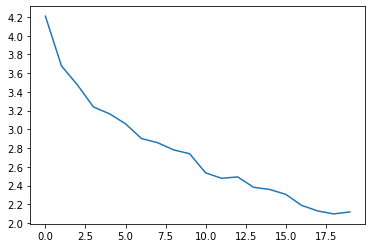

In [73]:
hidden_size =EncoderRNN
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
plot_losses = trainIters(encoder1, attn_decoder1, 20000, print_every=1000, plot_every=1000)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
eng 2803
fra 2803
0m 37s (- 11m 58s) (1000 5%) 3.4621
1m 16s (- 11m 31s) (2000 10%) 2.6391
1m 53s (- 10m 43s) (3000 15%) 2.3344
2m 29s (- 9m 56s) (4000 20%) 2.0306
3m 7s (- 9m 23s) (5000 25%) 1.8655
3m 42s (- 8m 38s) (6000 30%) 1.6410
4m 18s (- 8m 0s) (7000 35%) 1.5584
4m 56s (- 7m 24s) (8000 40%) 1.4047
5m 36s (- 6m 50s) (9000 45%) 1.3019
6m 14s (- 6m 14s) (10000 50%) 1.2099
6m 52s (- 5m 37s) (11000 55%) 1.0736
7m 28s (- 4m 58s) (12000 60%) 0.9735
8m 5s (- 4m 21s) (13000 65%) 0.9636
8m 45s (- 3m 45s) (14000 70%) 0.9072
9m 25s (- 3m 8s) (15000 75%) 0.8515
10m 5s (- 2m 31s) (16000 80%) 0.8301
10m 44s (- 1m 53s) (17000 85%) 0.7379
11m 24s (- 1m 16s) (18000 90%) 0.6642
12m 2s (- 0m 38s) (19000 95%) 0.6279
12m 38s (- 0m 0s) (20000 100%) 0.6552


<Figure size 432x288 with 0 Axes>

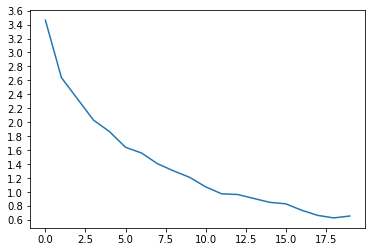

In [23]:
hidden_size = 256

input_lang, output_lang, pairs = prepareAEData('eng', 'fra', False)

AE_encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
AE_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
plot_losses = trainIters(AE_encoder, AE_decoder, 20000, print_every=1000, plot_every=1000)

torch.save(AE_encoder.state_dict(), 'AE_encoder.dict')
torch.save(AE_decoder.state_dict(), 'AE_decoder.dict')

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
eng 2803
fra 4345
0m 54s (- 17m 8s) (1000 5%) 4.0304
1m 47s (- 16m 9s) (2000 10%) 3.5425
2m 44s (- 15m 33s) (3000 15%) 3.3571
3m 33s (- 14m 14s) (4000 20%) 3.1280
4m 27s (- 13m 21s) (5000 25%) 3.0609
5m 17s (- 12m 21s) (6000 30%) 2.9662
6m 11s (- 11m 29s) (7000 35%) 2.7921
7m 7s (- 10m 41s) (8000 40%) 2.7819
8m 2s (- 9m 49s) (9000 45%) 2.6988
8m 52s (- 8m 52s) (10000 50%) 2.6582
9m 43s (- 7m 57s) (11000 55%) 2.5088
10m 37s (- 7m 5s) (12000 60%) 2.4530
11m 27s (- 6m 10s) (13000 65%) 2.4794
12m 18s (- 5m 16s) (14000 70%) 2.4184
13m 9s (- 4m 23s) (15000 75%) 2.3603
14m 6s (- 3m 31s) (16000 80%) 2.3658
15m 5s (- 2m 39s) (17000 85%) 2.2530
15m 57s (- 1m 46s) (18000 90%) 2.2155
16m 46s (- 0m 52s) (19000 95%) 2.2003
17m 39s (- 0m 0s) (20000 100%) 2.2154


<Figure size 432x288 with 0 Axes>

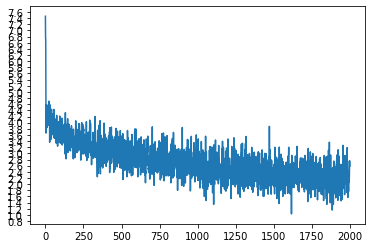

In [26]:
#use AE_encoder and new decoder for translation
input_lang, output_lang, pairs = prepareData('eng', 'fra', False)

attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
plot_losses = trainIters(AE_encoder, attn_decoder1, 20000, print_every=1000, plot_every = 10, enc_learning_rate=0)

In [128]:
help(AE_encoder)

Help on EncoderRNN in module __main__ object:

class EncoderRNN(torch.nn.modules.module.Module)
 |  EncoderRNN(input_size, hidden_size)
 |  
 |  Method resolution order:
 |      EncoderRNN
 |      torch.nn.modules.module.Module
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, input_size, hidden_size)
 |      Initializes internal Module state, shared by both nn.Module and ScriptModule.
 |  
 |  forward(self, input, hidden)
 |      Defines the computation performed at every call.
 |      
 |      Should be overridden by all subclasses.
 |      
 |      .. note::
 |          Although the recipe for forward pass needs to be defined within
 |          this function, one should call the :class:`Module` instance afterwards
 |          instead of this since the former takes care of running the
 |          registered hooks while the latter silently ignores them.
 |  
 |  initHidden(self)
 |  
 |  ---------------------------------------------------------------------

In [27]:
evaluateRandomly(AE_encoder, attn_decoder1)

> i m the youngest child .
= je suis la plus jeune enfant .
< je suis le meme . <EOS>

> she s my first love .
= elle est mon premier amour .
< elle est est le . . <EOS>

> i m writing a book .
= je suis en train d ecrire un bouquin .
< je suis un train . . <EOS>

> i m no longer angry at you .
= je ne suis plus en colere apres vous .
< je ne suis plus en colere . <EOS>

> i m contagious .
= je suis contagieuse .
< je suis rejouis . <EOS>

> i am convinced that he is innocent .
= je suis convaincu de son innocence .
< je suis certain qu il est <EOS>

> i m in way over my head .
= j ai des ennuis jusqu au cou .
< je suis en . de ma voiture . . <EOS>

> i m stubborn .
= je suis obstine .
< je suis en . <EOS>

> they are collecting contributions for the church .
= ils collectent des dons pour l eglise .
< ils sont en train de la voyage . <EOS>

> i m really sleepy .
= j ai vraiment sommeil .
< je suis vraiment vraiment . <EOS>



In [133]:
AE_encoder.state_dict()

OrderedDict([('embedding.weight',
              tensor([[-0.1075, -1.4561, -0.9269,  ..., -0.5095,  2.1325, -0.2530],
                      [ 1.0590, -2.3225,  2.6499,  ..., -1.7026, -0.4011, -1.4441],
                      [-0.3590,  0.9642,  0.0719,  ..., -0.8602, -2.1549,  0.8839],
                      ...,
                      [-1.6855,  1.0948,  0.1890,  ...,  1.2942,  0.6984, -0.0205],
                      [-1.1715, -0.4992,  1.0895,  ..., -0.9463,  0.3902, -0.2431],
                      [ 1.1411, -0.2259, -1.5470,  ...,  1.7607, -0.5163, -0.9703]])),
             ('gru.weight_ih_l0',
              tensor([[-0.0435,  0.0142, -0.0385,  ..., -0.0007,  0.0494,  0.0118],
                      [ 0.0231,  0.0476,  0.0293,  ...,  0.0334,  0.0247,  0.0224],
                      [-0.0404, -0.0577,  0.0246,  ..., -0.0609,  0.0534,  0.0044],
                      ...,
                      [ 0.0035,  0.1048,  0.0294,  ...,  0.0401, -0.0350,  0.1113],
                      [ 0.0081,  0.

In [140]:
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
encoder.load_state_dict(torch.load('AE_encoder.dict'))

encoder.state_dict()

OrderedDict([('embedding.weight',
              tensor([[-0.1075, -1.4561, -0.9269,  ..., -0.5095,  2.1325, -0.2530],
                      [ 1.0590, -2.3225,  2.6499,  ..., -1.7026, -0.4011, -1.4441],
                      [-0.3590,  0.9642,  0.0719,  ..., -0.8602, -2.1549,  0.8839],
                      ...,
                      [-1.6855,  1.0948,  0.1890,  ...,  1.2942,  0.6984, -0.0205],
                      [-1.1715, -0.4992,  1.0895,  ..., -0.9463,  0.3902, -0.2431],
                      [ 1.1411, -0.2259, -1.5470,  ...,  1.7607, -0.5163, -0.9703]])),
             ('gru.weight_ih_l0',
              tensor([[-0.0435,  0.0142, -0.0385,  ..., -0.0007,  0.0494,  0.0118],
                      [ 0.0231,  0.0476,  0.0293,  ...,  0.0334,  0.0247,  0.0224],
                      [-0.0404, -0.0577,  0.0246,  ..., -0.0609,  0.0534,  0.0044],
                      ...,
                      [ 0.0035,  0.1048,  0.0294,  ...,  0.0401, -0.0350,  0.1113],
                      [ 0.0081,  0.

In [30]:
from torchtext.vocab import GloVe
vec = GloVe(name='6B', dim=50)

.vector_cache/glove.6B.zip: 862MB [03:32, 4.07MB/s]                             
100%|███████████████████████████████▉| 399999/400000 [00:07<00:00, 52504.91it/s]


In [50]:
my_embeddings = torch.nn.Embedding.from_pretrained(vec.vectors,freeze=True)

In [51]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = my_embeddings
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
hidden_size = 50
input_lang, output_lang, pairs = prepareData('eng', 'fra', False)

encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
plot_losses = trainIters(encoder1, attn_decoder1, 20000, print_every=1000, plot_every=1000)

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
eng 2803
fra 4345
0m 10s (- 3m 19s) (1000 5%) 4.3112
0m 21s (- 3m 13s) (2000 10%) 4.1056
0m 32s (- 3m 4s) (3000 15%) 4.0276
0m 43s (- 2m 54s) (4000 20%) 3.8823
0m 55s (- 2m 45s) (5000 25%) 3.8376
1m 6s (- 2m 34s) (6000 30%) 3.7878
1m 17s (- 2m 23s) (7000 35%) 3.6717
1m 28s (- 2m 13s) (8000 40%) 3.6597
1m 40s (- 2m 3s) (9000 45%) 3.5932
1m 52s (- 1m 52s) (10000 50%) 3.5514
2m 4s (- 1m 41s) (11000 55%) 3.4503
2m 17s (- 1m 31s) (12000 60%) 3.4005
2m 29s (- 1m 20s) (13000 65%) 3.3915


In [ ]:
evaluateRandomly(encoder1, attn_decoder1)